In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import LinearSVC

from tqdm import tqdm_notebook

In [2]:
def calc_predict_proba(model, X_test):
    prob_pos = model.decision_function(X_test)
    prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    return prob_pos

In [3]:
def train_model(model, X_train, y_train, X_test):
    X_train, y_train, X_test = X_train.copy(), y_train.copy(), X_test.copy()
    
    categorical_feature = X_train.columns[X_train.dtypes == object].tolist()
    if len(categorical_feature) > 0:
        for col in categorical_feature:
            X_train[col] = X_train[col].astype(str).fillna('nan')
            X_test[col] = X_test[col].astype(str).fillna('nan')
            all_records = pd.concat([X_train[[col]], X_test[[col]]], axis=0)[col]
            le = LabelEncoder()
            le.fit(all_records)
            X_train[col] = le.transform(X_train[col])
            X_test[col] = le.transform(X_test[col])
        if type(model) == lgb.sklearn.LGBMClassifier:
            X_train[categorical_feature] = X_train[categorical_feature].astype('category', copy=True)
            X_test[categorical_feature] = X_test[categorical_feature].astype('category', copy=True)
    
    if type(model) != lgb.sklearn.LGBMClassifier:
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    oof = np.zeros(X_train.shape[0])
    y_pred = np.zeros((X_test.shape[0], 5))
    oof_sigmoid_calibrated = np.zeros(X_train.shape[0])
    y_pred_sigmoid_calibrated = np.zeros((X_test.shape[0], 5))
    oof_isotonic_calibrated = np.zeros(X_train.shape[0])
    y_pred_isotonic_calibrated = np.zeros((X_test.shape[0], 5))

    for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
        print(f'Start {i+1} fold')
        print('-' * 20)
        X_tr, y_tr = X_train.iloc[train_index, :], y_train.iloc[train_index]
        X_val, y_val = X_train.iloc[valid_index, :], y_train.iloc[valid_index]
        
        # ふつうにfit predict
        if type(model) == lgb.sklearn.LGBMClassifier:
            model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=1000, verbose=1000)
        else:
            model.fit(X_tr, y_tr)
        if hasattr(model, 'predict_proba'):
            oof[valid_index] = model.predict_proba(X_val)[:, 1]
            y_pred[:, i] = model.predict_proba(X_test)[:, 1]  
        else:  # use decision function
            oof[valid_index] = calc_predict_proba(model, X_val)
            y_pred[:, i] = calc_predict_proba(model, X_test)
  

        # sigmoid calibration
        model_calib = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
        model_calib.fit(X_val, y_val)
        oof_sigmoid_calibrated[valid_index] = model_calib.predict_proba(X_val)[:, 1]
        y_pred_sigmoid_calibrated[:, i] = model_calib.predict_proba(X_test)[:, 1]
    
        # istonic calibration
        model_calib = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
        model_calib.fit(X_val, y_val)
        oof_isotonic_calibrated[valid_index] = model_calib.predict_proba(X_val)[:, 1]
        y_pred_isotonic_calibrated[:, i] = model_calib.predict_proba(X_test)[:, 1]
    
    return {
        'base': (oof, y_pred.mean(axis=1)),
        'sigmoid_calibrated': (oof_sigmoid_calibrated, y_pred_sigmoid_calibrated.mean(axis=1)),
        'isotonic_calibrated': (oof_isotonic_calibrated, y_pred_isotonic_calibrated.mean(axis=1))
    }

In [4]:
def get_data(name):
    if name == 'kaggle_amazon_employee_access':
        data = pd.read_csv('../data/amazon-employee-access-challenge/train.csv')
        X = data.drop('ACTION', axis=1)
        y = data['ACTION'].copy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
        return X_train, X_test, y_train, y_test
    elif name == 'kaggle_bnp_paribas':
        data = pd.read_csv('../data/bnp-paribas-cardif-claims-management/train.csv.zip')
        X = data.drop('target', axis=1)
        y = data['target'].copy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
        return X_train, X_test, y_train, y_test
    elif name == 'kaggle_springleaf':
        data = pd.read_csv('../data/springleaf-marketing-response/train.csv.zip', low_memory=False)
        X = data.drop('target', axis=1)
        y = data['target'].copy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
        return X_train, X_test, y_train, y_test
    elif name == 'openml_adult':
        data = pd.read_csv('../data/openml/dataset_183_adult.csv')
        X = data.drop('class', axis=1)
        y = data['class'].copy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
        return X_train, X_test, y_train, y_test
    elif name == 'openml_bank_marketing':
        data = pd.read_csv('../data/openml/bank-marketing.csv')
        X = data.drop('Class', axis=1)
        y = data['Class'].copy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
        return X_train, X_test, y_train, y_test
    elif name == 'openml_click':
        data = pd.read_csv('../data/openml/click_small_unlabeled.csv', low_memory=False)
        data = data[data.click!='?'].reset_index(drop=True)
        X = data.drop('click', axis=1)
        y = data['click'].copy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
        return X_train, X_test, y_train, y_test
    elif name == 'openml_mozilla4':
        data = pd.read_csv('../data/openml/mozilla4.csv', low_memory=False)
        X = data.drop('state', axis=1)
        y = data['state'].copy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
        return X_train, X_test, y_train, y_test
    elif name == 'openml_eeg_eye_state':
        data = pd.read_csv('../data/openml/eeg-eye-state.csv', low_memory=False)
        X = data.drop('Class', axis=1)
        y = data['Class'].copy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
        return X_train, X_test, y_train, y_test
    elif name == 'openml_electricity':
        data = pd.read_csv('../data/openml/electricity-normalized.csv', low_memory=False)
        X = data.drop('class', axis=1)
        y = data['class'].copy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
        return X_train, X_test, y_train, y_test

In [5]:
dataset_names = [
    'kaggle_amazon_employee_access',
    'kaggle_bnp_paribas',
    'kaggle_springleaf',
    'openml_adult',
    'openml_bank_marketing',
    'openml_click',
    'openml_mozilla4',
    'openml_eeg_eye_state',
    'openml_electricity'
]

In [6]:
results = []
for name in tqdm_notebook(dataset_names):
    X_train, X_test, y_train, y_test = get_data(name)
    result = train_model(
        lgb.LGBMClassifier(
            objective='binary',
            max_depth=8,
            num_leaves=2 ** 8,
            subsample=0.8,
            random_state=0,
            metric='auc',
            learning_rate=0.01,
            n_estimators=100000000
        ), 
        X_train, y_train, X_test)
    results.append(result)

Start 1 fold
--------------------
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's auc: 0.837839
[2000]	valid_0's auc: 0.84272
Early stopping, best iteration is:
[1584]	valid_0's auc: 0.844762
Start 2 fold
--------------------
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's auc: 0.822052
[2000]	valid_0's auc: 0.823675
[3000]	valid_0's auc: 0.826097
Early stopping, best iteration is:
[2805]	valid_0's auc: 0.827043
Start 3 fold
--------------------
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's auc: 0.816756
[2000]	valid_0's auc: 0.808948
Early stopping, best iteration is:
[1044]	valid_0's auc: 0.816957
Start 4 fold
--------------------
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's auc: 0.821132
[2000]	valid_0's auc: 0.826569
Early stopping, best iteration is:
[1824]	valid_0's auc: 0.82753
Start 5 fold
--------------------
Training until validation scores don'

[1000]	valid_0's auc: 0.979857
[2000]	valid_0's auc: 0.988447
[3000]	valid_0's auc: 0.990425
[4000]	valid_0's auc: 0.991094
[5000]	valid_0's auc: 0.991277
[6000]	valid_0's auc: 0.991719
[7000]	valid_0's auc: 0.991906
[8000]	valid_0's auc: 0.992021
[9000]	valid_0's auc: 0.992059
[10000]	valid_0's auc: 0.99216
[11000]	valid_0's auc: 0.992161
Early stopping, best iteration is:
[10565]	valid_0's auc: 0.992199
Start 3 fold
--------------------
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's auc: 0.97671
[2000]	valid_0's auc: 0.984883
[3000]	valid_0's auc: 0.98642
[4000]	valid_0's auc: 0.986431
[5000]	valid_0's auc: 0.986953
[6000]	valid_0's auc: 0.987129
[7000]	valid_0's auc: 0.987338
[8000]	valid_0's auc: 0.987405
[9000]	valid_0's auc: 0.987589
[10000]	valid_0's auc: 0.987702
[11000]	valid_0's auc: 0.987824
[12000]	valid_0's auc: 0.987917
[13000]	valid_0's auc: 0.987891
Early stopping, best iteration is:
[12042]	valid_0's auc: 0.987927
Start 4 fold
---------

In [7]:
lgb_results = []
for name, result in zip(dataset_names, results):
    _, _, _, y_test = get_data(name)
    lgb_results.append((name, y_test, result['base'][1], result['sigmoid_calibrated'][1], result['isotonic_calibrated'][1]))

kaggle_amazon_employee_access AUC: 0.8484711510698768
kaggle_bnp_paribas AUC: 0.7505219850122518
kaggle_springleaf AUC: 0.7604182857063828
openml_adult AUC: 0.9161453084695707
openml_bank_marketing AUC: 0.9298938786288393
openml_click AUC: 0.744847854749338
openml_mozilla4 AUC: 0.983313259484187
openml_eeg_eye_state AUC: 0.9912845200022443
openml_electricity AUC: 0.9864779780139128


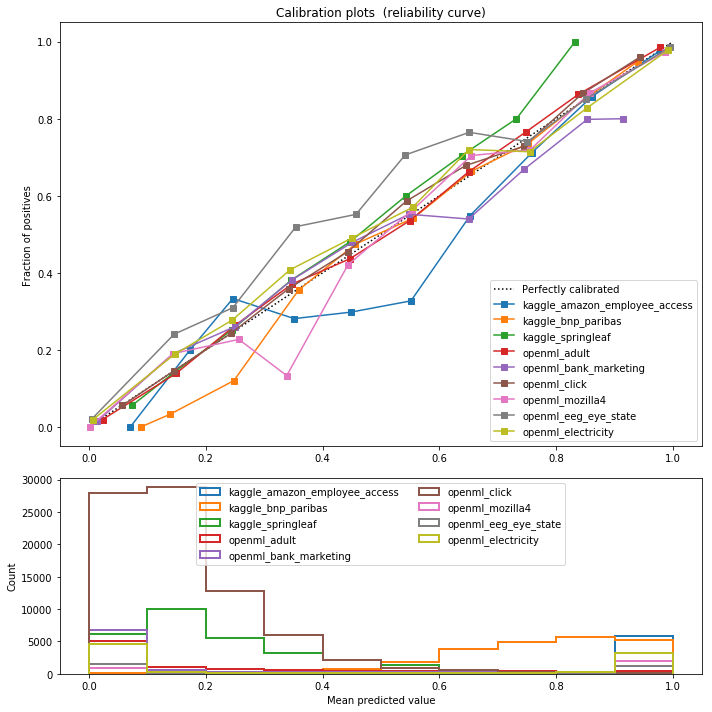

In [8]:
# 各datasetのlgbによるtestデータのcailbration curveをまとめてかく
# Plot calibration plots
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for name, y_true, y_pred, _, _ in lgb_results:
    print(f'{name} AUC: {roc_auc_score(y_true, y_pred)}')
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred, n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (name, ))
    ax2.hist(y_pred, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.savefig('../output/lgb_calibration_plots.png', dpi=300)

lgb AUC: 0.8484711510698768
sigmoid AUC: 0.8473944907692468
isotonic AUC: 0.8475701655517406
lgb AUC: 0.7505219850122518
sigmoid AUC: 0.7391271854429098
isotonic AUC: 0.7390950373598224
lgb AUC: 0.7604182857063828
sigmoid AUC: 0.7571821619705721
isotonic AUC: 0.75716853216753
lgb AUC: 0.9161453084695707
sigmoid AUC: 0.9161402394800405
isotonic AUC: 0.9161271591564828
lgb AUC: 0.9298938786288393
sigmoid AUC: 0.9300492529536446
isotonic AUC: 0.9298150715452791
lgb AUC: 0.744847854749338
sigmoid AUC: 0.7448355027497693
isotonic AUC: 0.7447948564051601
lgb AUC: 0.983313259484187
sigmoid AUC: 0.9832105341528741
isotonic AUC: 0.9830338277343316
lgb AUC: 0.9912845200022443
sigmoid AUC: 0.9911736520226674
isotonic AUC: 0.9914059361499187
lgb AUC: 0.9864779780139128
sigmoid AUC: 0.9863796548918246
isotonic AUC: 0.9864818172027571


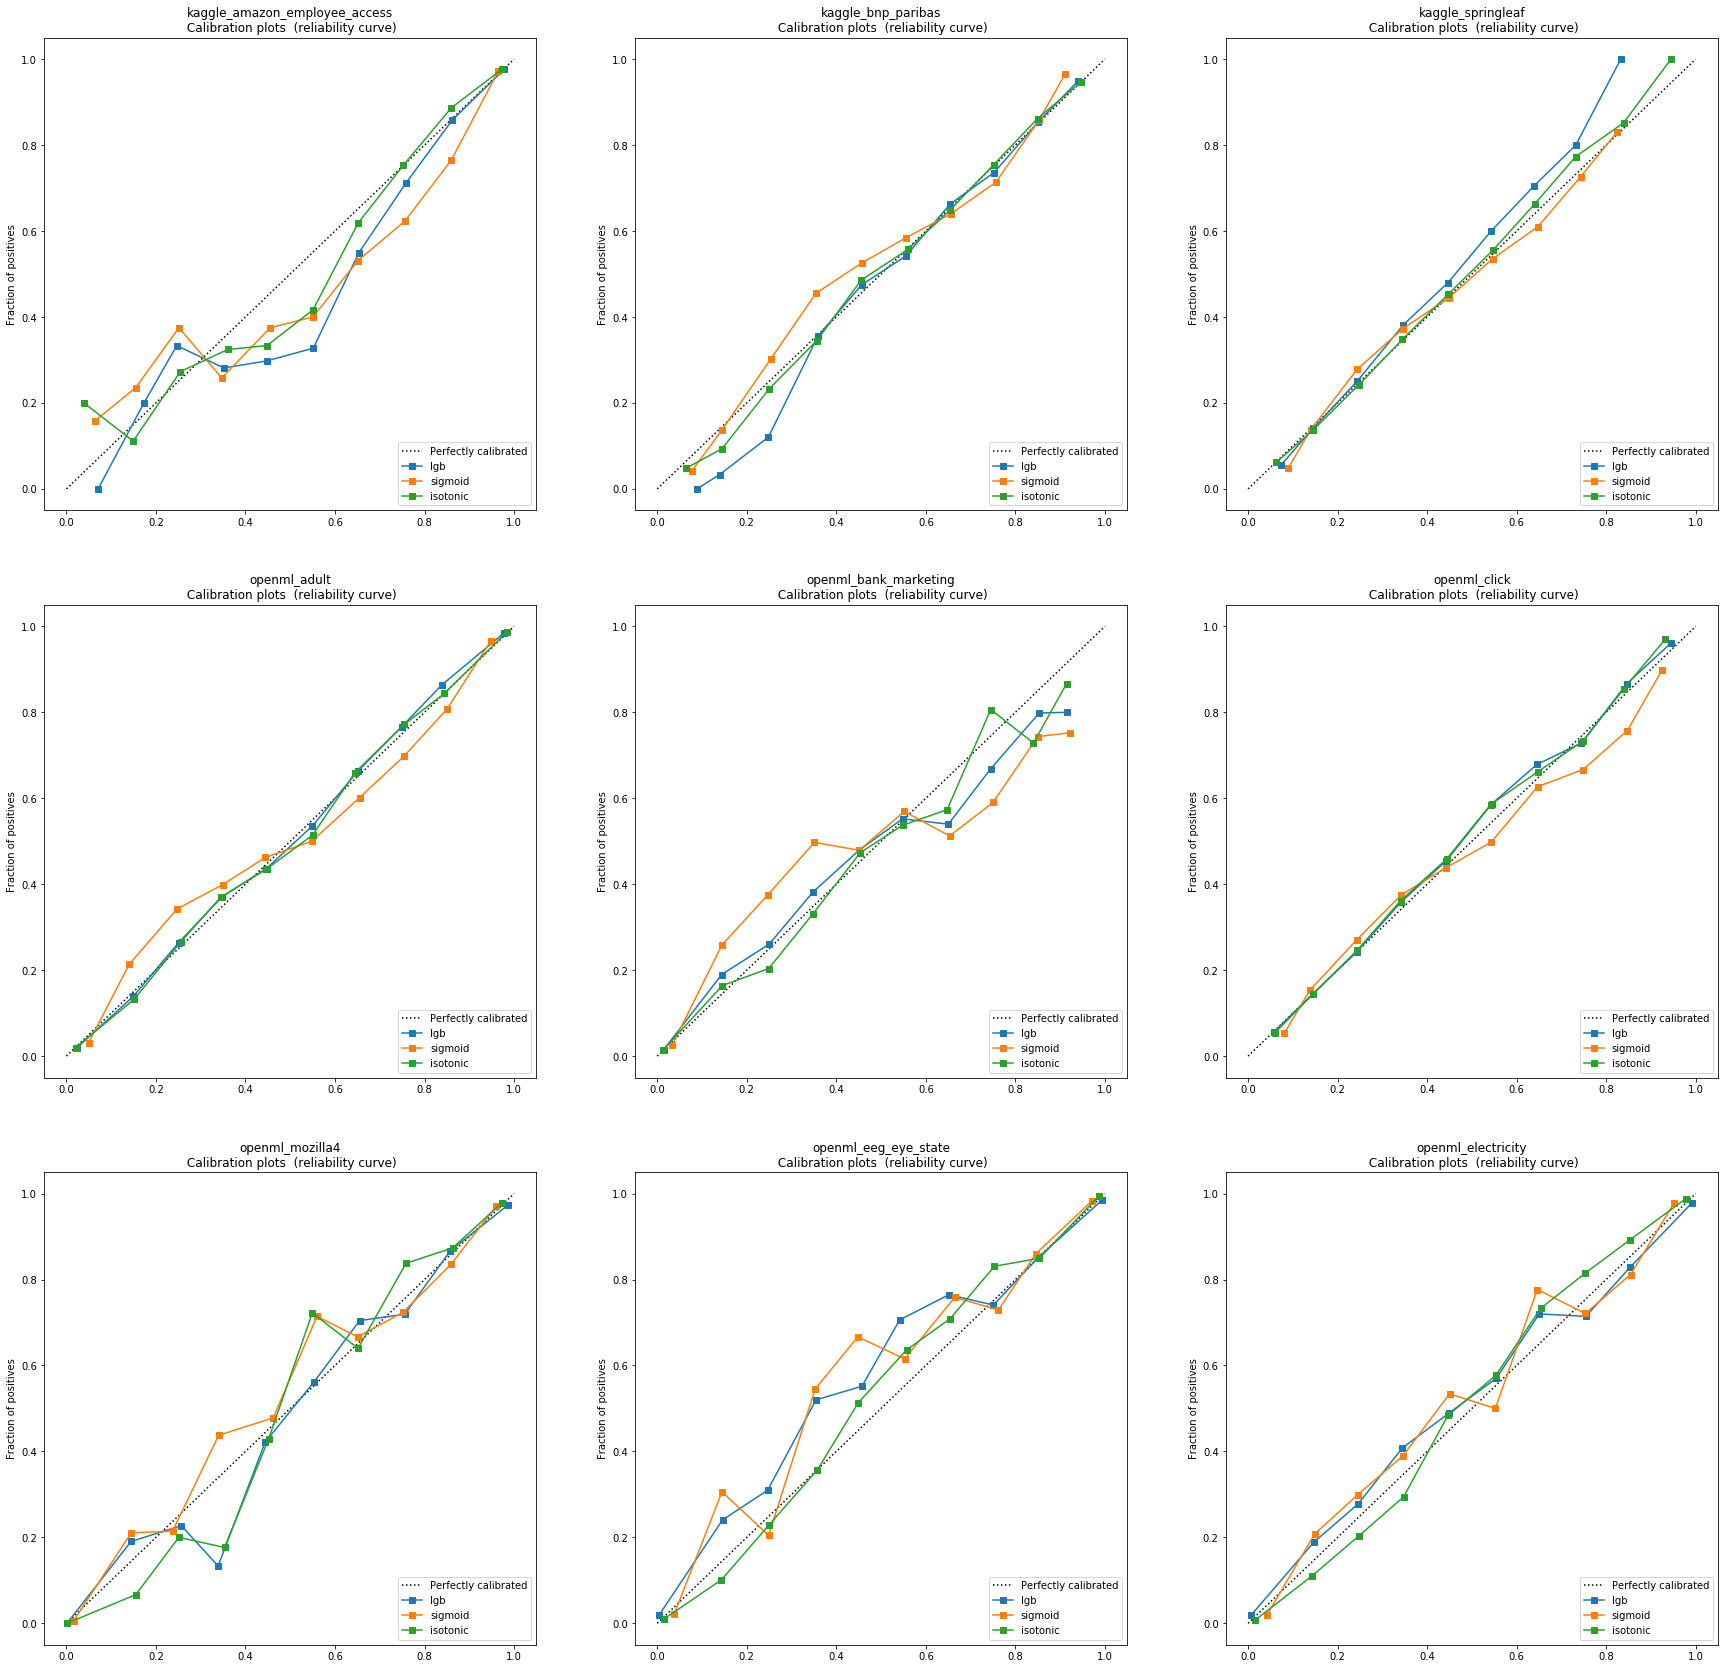

In [9]:
# datasetごとにlgbそのまま、sigmoid およびisotonic calibrationしたときのplotをかく
fig = plt.figure(figsize=(30, 40))

for i, (name, y_true, y_pred_lgb, y_pred_sigmoid, y_pred_isotonic) in enumerate(lgb_results):
    ax = fig.add_subplot(4, 3, i+1)
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for calibraton_type, y_pred in zip(['lgb', 'sigmoid', 'isotonic'], [y_pred_lgb, y_pred_sigmoid, y_pred_isotonic]):
        print(f'{calibraton_type} AUC: {roc_auc_score(y_true, y_pred)}')
        fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred, n_bins=10)
        ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (calibraton_type, ))

    ax.set_ylabel("Fraction of positives")
    ax.set_ylim([-0.05, 1.05])
    ax.legend(loc="lower right")
    ax.set_title(f'{name}\n Calibration plots  (reliability curve)')

#plt.savefig('../output/lgb_calibration_plots.png', dpi=300)

In [10]:
fig.tight_layout()
fig.savefig('../output/calibrated_predictions.png')

In [11]:
dataset_names

['kaggle_amazon_employee_access',
 'kaggle_bnp_paribas',
 'kaggle_springleaf',
 'openml_adult',
 'openml_bank_marketing',
 'openml_click',
 'openml_mozilla4',
 'openml_eeg_eye_state',
 'openml_electricity']

In [12]:
# 比較用にRandomForestでもやってみる
results = []
for name in tqdm_notebook(dataset_names):
    X_train, X_test, y_train, y_test = get_data(name)
    result = train_model(RandomForestClassifier(n_estimators=300), X_train, y_train, X_test)
    results.append(result)

Start 1 fold
--------------------
Start 2 fold
--------------------
Start 3 fold
--------------------
Start 4 fold
--------------------
Start 5 fold
--------------------
Start 1 fold
--------------------
Start 2 fold
--------------------
Start 3 fold
--------------------
Start 4 fold
--------------------
Start 5 fold
--------------------
Start 1 fold
--------------------
Start 2 fold
--------------------
Start 3 fold
--------------------
Start 4 fold
--------------------
Start 5 fold
--------------------
Start 1 fold
--------------------
Start 2 fold
--------------------
Start 3 fold
--------------------
Start 4 fold
--------------------
Start 5 fold
--------------------
Start 1 fold
--------------------
Start 2 fold
--------------------
Start 3 fold
--------------------
Start 4 fold
--------------------
Start 5 fold
--------------------
Start 1 fold
--------------------
Start 2 fold
--------------------
Start 3 fold
--------------------
Start 4 fold
--------------------
Start 5 fold
-

In [13]:
rf_results = []
for name, result in zip(dataset_names, results):
    _, _, _, y_test = get_data(name)
    rf_results.append((name, y_test, result['base'][1], result['sigmoid_calibrated'][1], result['isotonic_calibrated'][1]))

kaggle_amazon_employee_access AUC: 0.8481287156955851
kaggle_bnp_paribas AUC: 0.7496741109211673
kaggle_springleaf AUC: 0.7702145364372494
openml_adult AUC: 0.8924709424545002
openml_bank_marketing AUC: 0.9260443559510253
openml_click AUC: 0.7101295425251254
openml_mozilla4 AUC: 0.9858401612693458
openml_eeg_eye_state AUC: 0.9789498962015373
openml_electricity AUC: 0.970240029078116


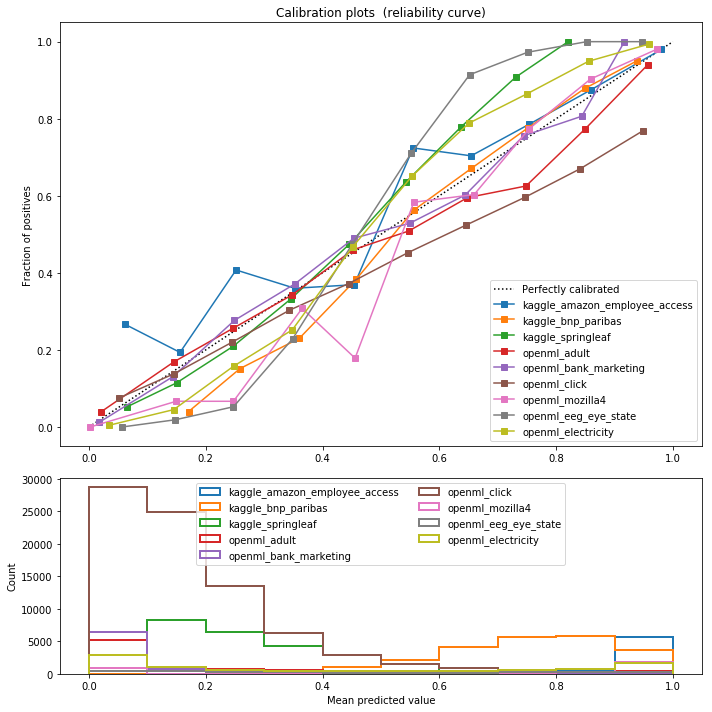

In [14]:
# 各datasetのrfによるtestデータのcailbration curveをまとめてかく
# Plot calibration plots
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for name, y_true, y_pred, _, _ in rf_results:
    print(f'{name} AUC: {roc_auc_score(y_true, y_pred)}')
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred, n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (name, ))
    ax2.hist(y_pred, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.savefig('../output/rf_calibration_plots.png', dpi=300)

lgb AUC: 0.8481287156955851
sigmoid AUC: 0.8482759085517093
isotonic AUC: 0.8488833780347385
lgb AUC: 0.7496741109211673
sigmoid AUC: 0.7497524850405026
isotonic AUC: 0.7495486259559578
lgb AUC: 0.7702145364372494
sigmoid AUC: 0.7701853344841105
isotonic AUC: 0.7700568325408357
lgb AUC: 0.8924709424545002
sigmoid AUC: 0.8925033373760953
isotonic AUC: 0.8923962185571161
lgb AUC: 0.9260443559510253
sigmoid AUC: 0.9259705000978458
isotonic AUC: 0.9259491626526335
lgb AUC: 0.7101295425251254
sigmoid AUC: 0.7102936887043783
isotonic AUC: 0.710218612897061
lgb AUC: 0.9858401612693458
sigmoid AUC: 0.985674057235916
isotonic AUC: 0.9858019926829407
lgb AUC: 0.9789498962015373
sigmoid AUC: 0.9790688436290188
isotonic AUC: 0.9788372327890927
lgb AUC: 0.970240029078116
sigmoid AUC: 0.9702476825260068
isotonic AUC: 0.970079506110792


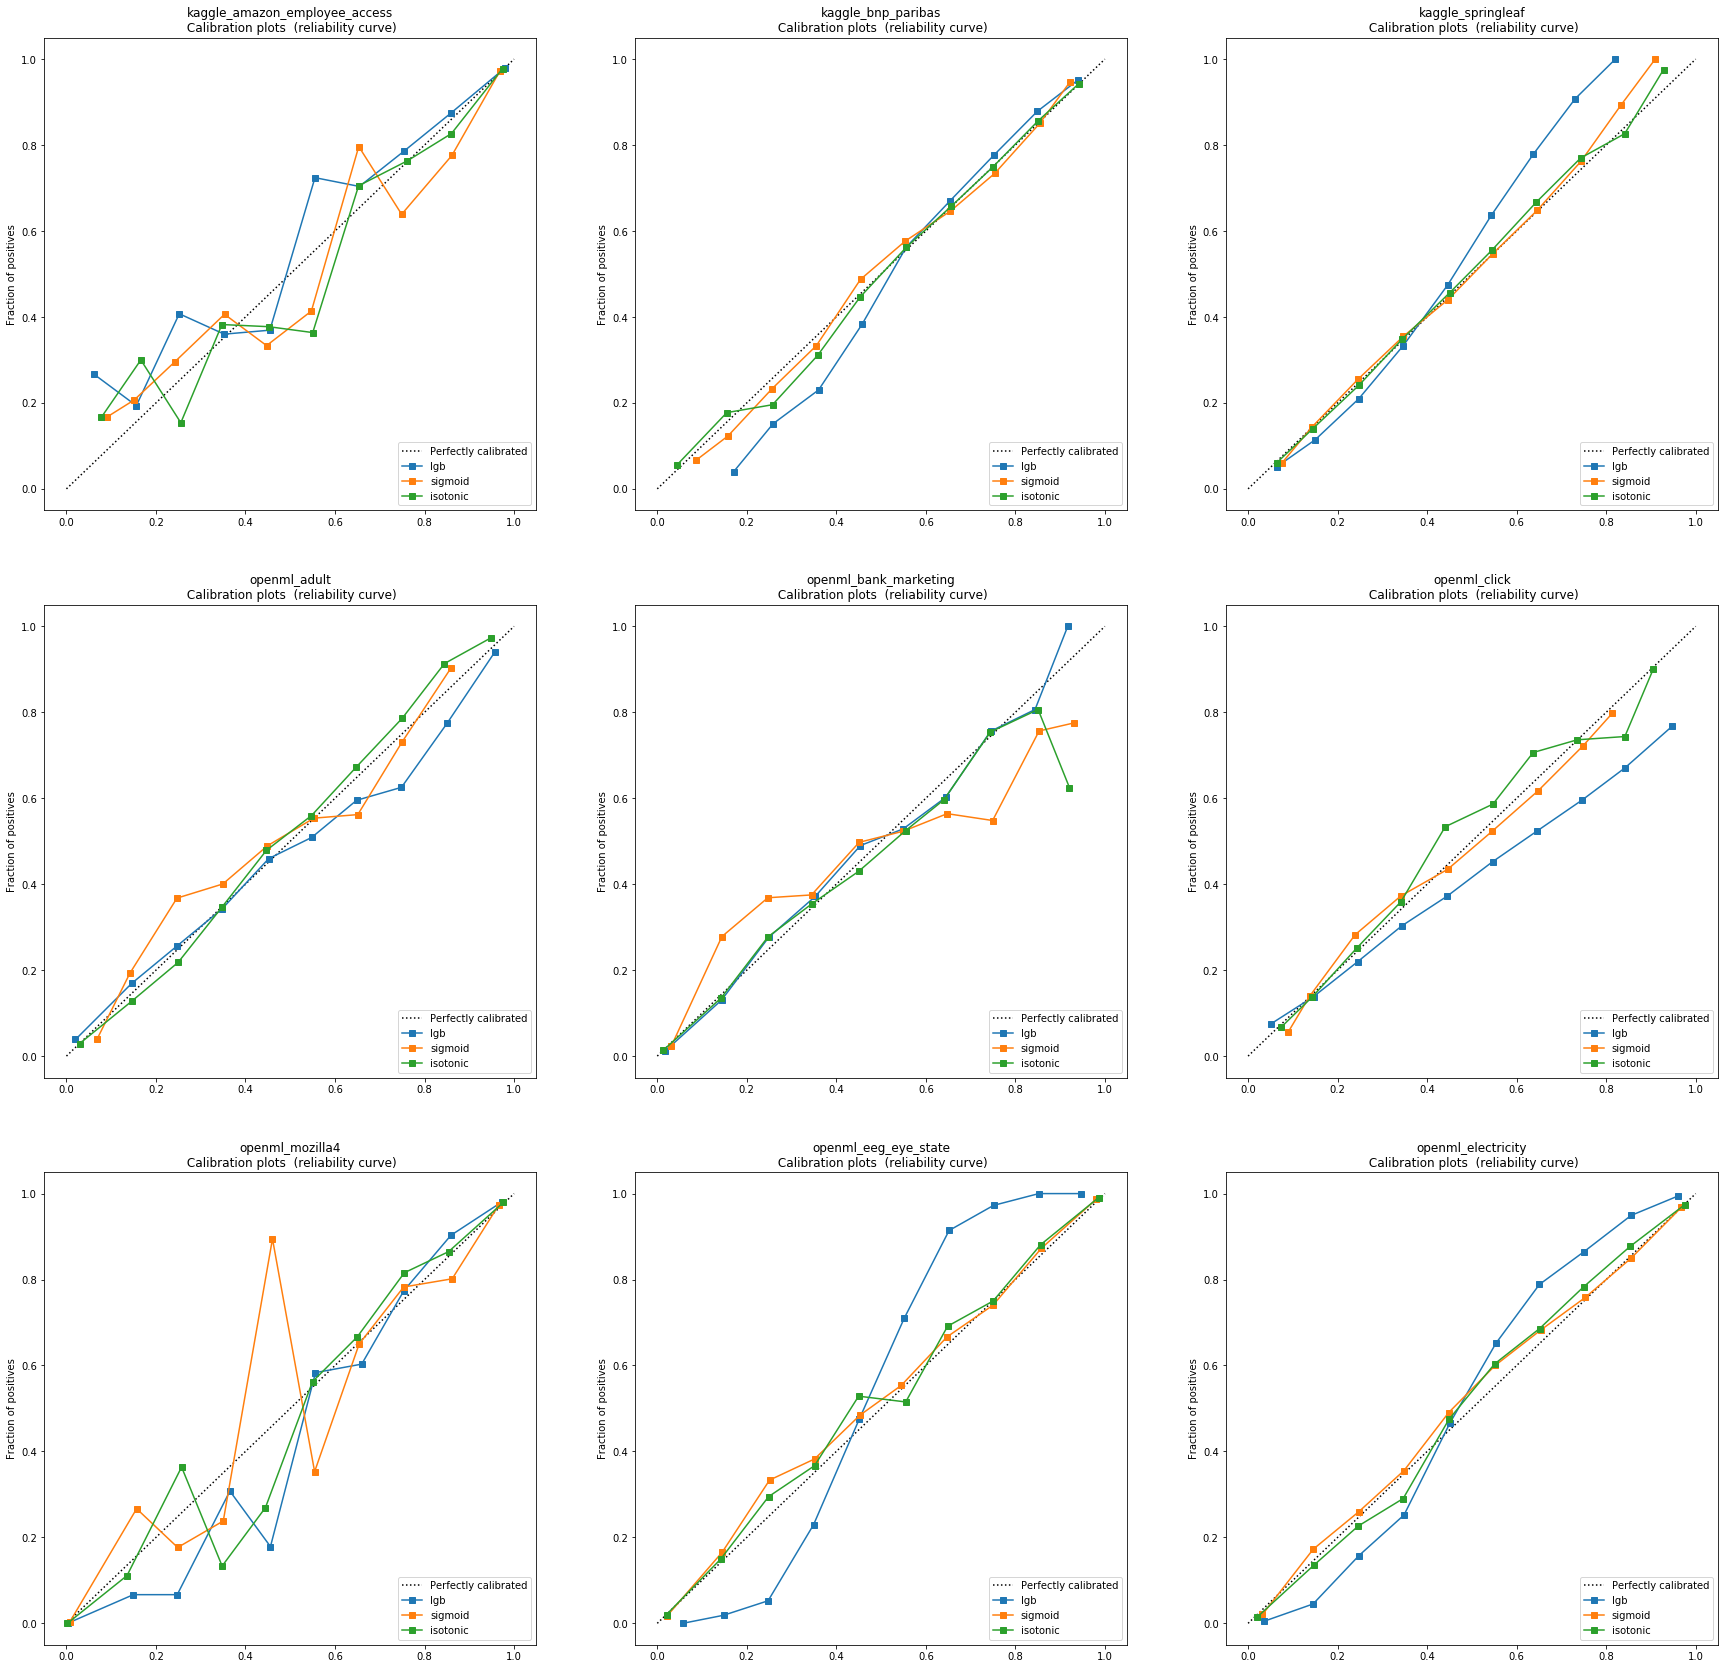

In [15]:
# datasetごとにlgbそのまま、sigmoid およびisotonic calibrationしたときのplotをかく
fig = plt.figure(figsize=(30, 40))

for i, (name, y_true, y_pred_lgb, y_pred_sigmoid, y_pred_isotonic) in enumerate(rf_results):
    ax = fig.add_subplot(4, 3, i+1)
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for calibraton_type, y_pred in zip(['lgb', 'sigmoid', 'isotonic'], [y_pred_lgb, y_pred_sigmoid, y_pred_isotonic]):
        print(f'{calibraton_type} AUC: {roc_auc_score(y_true, y_pred)}')
        fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred, n_bins=10)
        ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (calibraton_type, ))

    ax.set_ylabel("Fraction of positives")
    ax.set_ylim([-0.05, 1.05])
    ax.legend(loc="lower right")
    ax.set_title(f'{name}\n Calibration plots  (reliability curve)')

#plt.savefig('../output/lgb_calibration_plots.png', dpi=300)

In [16]:
fig.tight_layout()
fig.savefig('../output/rf_calibrated_predictions.png')